In [1]:
%matplotlib notebook
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import numpy as np

# EMC3 data reading

In [2]:
felix_folder = "/u/flr/data/EMC3-runs/W7X/EIM-SC/EFFENBERG"
# seperatrix density
# input power in seperatrix
# impurity transport coefficient
# radiation fraction of input power
# impurity type
experiment = "N03.00_P05.00_D05_R02.00-C"
# "N03.00_P05.00_D05_C04.50-TEST"  # "N04.00_P02.50_D05_R02.00-N"  # 
#ds = xemc3.load.all(f"{felix_folder}/{experiment}")
# ds.to_netcdf(f"{experiment}.nc")

In [3]:
# everything (including geometry data)
ds = xr.open_dataset(f"../atomdatpy/NetCDFs-new/{experiment}.nc")
# Ez only (only useful with precalculated xemc3 geom matrix)
#ds = xr.open_dataset(f"../atomdatpy/NetCDFs/{experiment}_Ez.nc")

In [4]:
ds["Ezsum"] = ds["Ez"].sum(dim="Ionization", skipna=False)

In [5]:
bolotype = "QRB"
ds_gabr = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
sightlines = ds_gabr.los
sightline_names = ds_gabr.id

In [6]:
sightlines[0]

<xarray.DataArray 'los' (hit: 2, xyz: 3)>
array([[-5.456615, -2.206791, -1.016647],
       [-6.603495, -2.344544,  1.752051]])
Dimensions without coordinates: hit, xyz

In [7]:
def crossec_pcolorgrid(ds, phi):
    # (A+1)*(B+1) = AB + A + B +1
    outR = np.empty((len(ds["r"])+1, len(ds["theta"])+1))
    outZ = outR.copy()
    
    outR[:-1,:-1] = ds["R_bounds"][ :, :,phi,0,0,0]  # AB
    outR[:-1, -1] = ds["R_bounds"][ :,-1,phi,0,1,0]  # A
    outR[ -1,:-1] = ds["R_bounds"][-1, :,phi,1,0,0]  # B
    outR[ -1, -1] = ds["R_bounds"][-1,-1,phi,1,1,0]  # 1
    
    outZ[:-1,:-1] = ds["z_bounds"][ :, :,phi,0,0,0]  # AB
    outZ[:-1, -1] = ds["z_bounds"][ :,-1,phi,0,1,0]  # A
    outZ[ -1,:-1] = ds["z_bounds"][-1, :,phi,1,0,0]  # B
    outZ[ -1, -1] = ds["z_bounds"][-1,-1,phi,1,1,0]  # 1
    
    return outR, outZ

def combination_plot(bolo_name="AEE", bolo_index=0, bolo_type="QSB", prec=1000, sf = lambda x: np.log(x+1e-4)):
    ds_gabr = xr.open_dataset(f"../Gabriele/{bolo_type}-dataset.nc")
    sightlines = ds_gabr.los
    sightline_names = ds_gabr.id
    
    # find foil index
    full_name = f"{bolo_name} Foil {bolo_index}"
    index = np.nonzero((sightline_names == full_name).values)[0][0]
    
    
    A, B = sightlines[index][0].values, sightlines[index][1].values
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,7))
    ds["Eztemp"] = ds["Ezsum"]
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m

    # get mapping
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key=None,
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    
    m = mapped.assign(Ezsum=ds.Ezsum[mapped])
    m = m.assign(Ez=ds.Ez[mapped])
    
    # plot 1
    axs[0].plot(m["dr"], m["Ezsum"], c="grey", lw=2, zorder=100, label="total $E_Z$")
    for i in range(7):
        axs[0].plot(m["dr"], m["Ez"][i], label=f"$E_Z^{i}$")
    axs[0].set_title("Emissivity along sightline")
    axs[0].set_ylabel("$E_Z$ in $W/m^3$")
    axs[0].set_xlabel("coordinate along sightline in m")
    axs[0].legend()
    
    # plot 2
    ds["Ezcoloring"] = sf(ds["Ezsum"])
    #sightline_phi = np.searchsorted(ds["phi_bounds"][:,1], np.arctan2(A[1], A[0]) % (2*np.pi/10))
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    hmma = fma if fma < np.pi/5 else 2*np.pi/5 - fma # half module mapped angle
    hmma_index = np.searchsorted(ds.phi_bounds[:,1], hmma)
    is_flipped = fma > (2*np.pi/5 - fma)
    
    R,Z = crossec_pcolorgrid(ds, hmma_index)
    C = ds["Ezcoloring"].isel(phi=hmma_index)
    axs[1].pcolormesh(R, Z, C, cmap=mpl.cm.magma)
    
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    if is_flipped:
        z_sightline *= -1
    
    axs[1].set_aspect("equal")
    axs[1].axes.xaxis.set_ticklabels([])
    axs[1].axes.yaxis.set_ticklabels([])
    axs[1].axes.xaxis.set_visible(False)
    axs[1].axes.yaxis.set_visible(False)
    axs[1].plot(r_sightline, z_sightline, c="C1", zorder=1000)
    axs[1].plot(r_sightline, z_sightline, c="C1", zorder=1000)
    axs[1].set_ylim((-1.2,1.2))
    axs[1].set_xlim((4.5,6.6))
    
    fig.tight_layout()
    return fig, axs, m, length

In [8]:
#axs[0].set_yscale("log")
#axs[0].set_yscale("linear")

In [9]:
ds_gabr.id

<xarray.DataArray 'id' (foil: 88)>
array(['AEJCOR Foil 1', 'AEJCOR Foil 2', 'AEJCOR Foil 3', 'AEJCOR Foil 4',
       'AEJCOR Foil 5', 'AEJCOR Foil 6', 'AEJCOR Foil 7', 'AEJCOR Foil 8',
       'AEJCOR Foil 9', 'AEJCOR Foil 10', 'AEJCOR Foil 11', 'AEJCOR Foil 12',
       'AEJCOR Foil 13', 'AEJCOR Foil 14', 'AEJCOR Foil 15', 'AEJCOR Foil 16',
       'AEJCOR Foil 17', 'AEJCOR Foil 18', 'AEJCOR Foil 19', 'AEJCOR Foil 20',
       'AEJDIV Foil 1', 'AEJDIV Foil 2', 'AEJDIV Foil 3', 'AEJDIV Foil 4',
       'AEJDIV Foil 5', 'AEJDIV Foil 6', 'AEJDIV Foil 7', 'AEJDIV Foil 8',
       'AEJDIV Foil 9', 'AEJDIV Foil 10', 'AEJDIV Foil 11', 'AEJDIV Foil 12',
       'AEJDIV Foil 13', 'AEJDIV Foil 14', 'AEJDIV Foil 15', 'AEJDIV Foil 16',
       'AEJDIV Foil 17', 'AEJDIV Foil 18', 'AEJDIV Foil 19', 'AEJDIV Foil 20',
       'AEJDIV Foil 21', 'AEJDIV Foil 22', 'AEJDIV Foil 23', 'AEJDIV Foil 24',
       'AEJDIV Foil 25', 'AEJDIV Foil 26', 'AEJDIV Foil 27', 'AEJDIV Foil 28',
       'AELBOT Foil 1', 'AELBOT Foil 2', 'AELBOT Foil 3', 'AELBOT Foil 4',
       'AELBOT Foil 5', 'AELBOT Foil 6', 'AELBOT Foil 7', 'AELBOT Foil 8',
       'AELBOT Foil 9', 'AELBOT Foil 10', 'AELBOT Foil 11', 'AELBOT Foil 12',
       'AELBOT Foil 13', 'AELBOT Foil 14', 'AELBOT Foil 15', 'AELBOT Foil 16',
       'AELBOT Foil 17', 'AELBOT Foil 18', 'AELBOT Foil 19', 'AELBOT Foil 20',
       'AELTOP Foil 1', 'AELTOP Foil 2', 'AELTOP Foil 3', 'AELTOP Foil 4',
       'AELTOP Foil 5', 'AELTOP Foil 6', 'AELTOP Foil 7', 'AELTOP Foil 8',
       'AELTOP Foil 9', 'AELTOP Foil 10', 'AELTOP Foil 11', 'AELTOP Foil 12',
       'AELTOP Foil 13', 'AELTOP Foil 14', 'AELTOP Foil 15', 'AELTOP Foil 16',
       'AELTOP Foil 17', 'AELTOP Foil 18', 'AELTOP Foil 19', 'AELTOP Foil 20'],
      dtype=object)
Dimensions without coordinates: foil

<IPython.core.display.Javascript object>


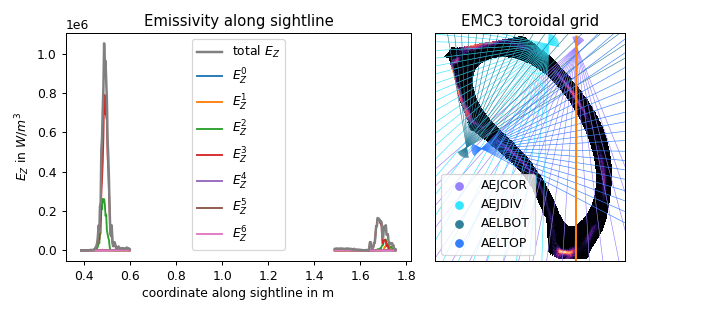

In [10]:
fig, axs, *_ = combination_plot(bolo_name="AEJCOR", bolo_index=7, bolo_type="QRB", sf = lambda x: np.log(x+1e5))
fig.set_size_inches(8, 3.5, forward=True)
#axs[0].legend(loc=1)
axs[1].set_ylim(-.75,1.05)
axs[1].set_xlim(4.8,6.3)
#axs[0].set_xlim(0.65, 1.09)
axs[1].set_title("EMC3 toroidal grid")
fig.tight_layout()
fig.tight_layout()
fig.tight_layout()

bolotype = "QRB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
color_dict = {"HBCm Foi": (0.2, 0.5, 1.0), "VBCr Foi": (0.2, 0.5, 1.0), "VBCl Foi": (0.2, 0.5, 1.0), 
              "AEJCOR F": (0.6, 0.5, 1.0), "AEJDIV F": (0.2, 0.9, 1.0), "AELBOT F": (0.2, 0.5, 0.6), "AELTOP F": (0.2, 0.5, 1.0)}
colors = [color_dict[s.data[()][:8]] for s in A_all.id]

already = []
for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:6] for s in A_all.id])):
    A, B = foil.isel(hit=0), foil.isel(hit=1)
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    is_flipped = fma > (2*np.pi/5 - fma)
    if is_flipped:
        z_sightline *= -1
    if label not in already:
        axs[1].scatter([1000], [1000], color=color, label=label)
        already.append(label)
    axs[1].plot(r_sightline, z_sightline, c=color, lw=0.5)

axs[1].legend(loc=3)

fig.savefig("./plots/sightlineintegral2.pdf")
fig.savefig("./plots/sightlineintegral2.png", dpi=200)

<IPython.core.display.Javascript object>


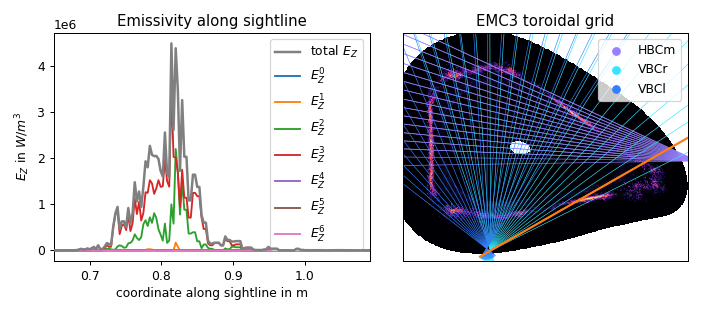

In [21]:
fig, axs, *_ = combination_plot(bolo_name="VBCr", bolo_index=2, bolo_type="QSB", sf = lambda x: np.log(x+1e5))
fig.set_size_inches(8, 3.5, forward=True)
axs[0].legend(loc=1)
axs[1].set_ylim(-.7,.9)
axs[1].set_xlim(4.4,6.4)
axs[0].set_xlim(0.65, 1.09)
axs[1].set_title("EMC3 toroidal grid")
fig.tight_layout()

bolotype = "QSB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
color_dict = {"HBCm Foi": (0.6, 0.5, 1.0), "VBCr Foi": (0.2, 0.9, 1.0), "VBCl Foi": (0.2, 0.5, 1.0), 
              "AEJCOR F": (0.6, 0.5, 1.0), "AEJDIV F": (0.2, 0.9, 1.0), "AELBOT F": (0.2, 0.5, 0.6), "AELTOP F": (0.2, 0.5, 1.0)}
colors = [color_dict[s.data[()][:8]] for s in A_all.id]

already = []
for i, (foil, color, label) in enumerate(zip(A_all.los, colors, [s.data[()][:4] for s in A_all.id])):
    A, B = foil.isel(hit=0), foil.isel(hit=1)
    r_sightline = np.array([(A[0]**2+A[1]**2)**(1/2),(B[0]**2+B[1]**2)**(1/2)])
    z_sightline = np.array([A[2], B[2]])
    fma = np.arctan2(A[1], A[0]) % (2*np.pi/5) # full module angle
    is_flipped = fma > (2*np.pi/5 - fma)
    if is_flipped:
        z_sightline *= -1
    if label not in already:
        axs[1].scatter([1000], [1000], color=color, label=label)
        already.append(label)
    axs[1].plot(r_sightline, z_sightline, c=color, lw=0.5)

axs[1].legend(loc=1)
fig.savefig("./plots/sightlineintegral.pdf")
fig.savefig("./plots/sightlineintegral.png", dpi=200)

In [22]:
ds_gabr.Etendue[33] * 1e7

<xarray.DataArray 'Etendue' ()>
array(0.03065094)

<IPython.core.display.Javascript object>


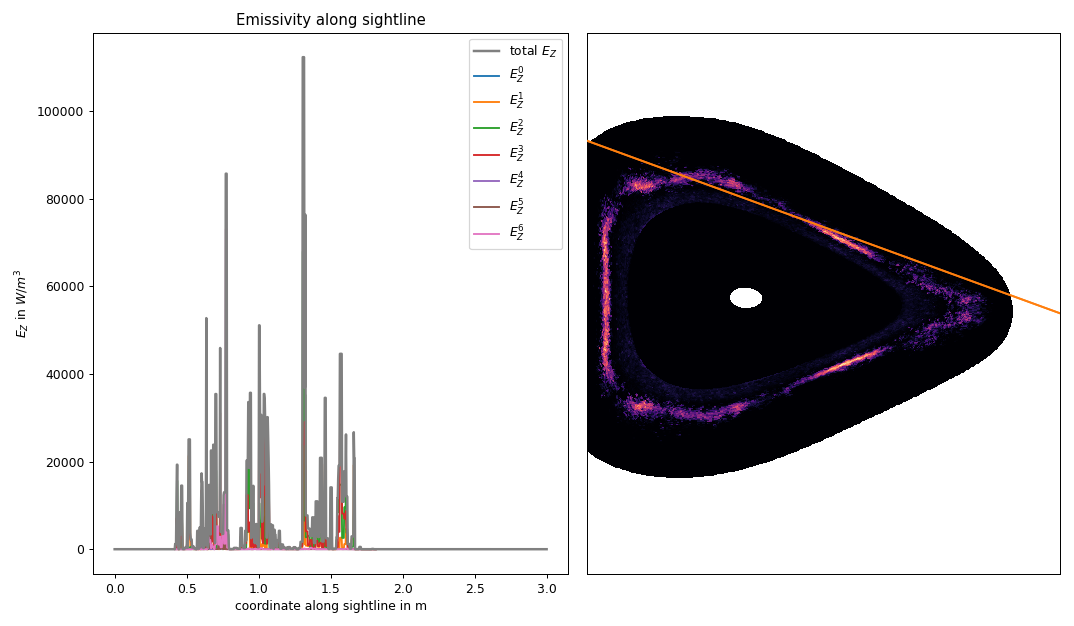

In [23]:
fig, axs, *_ = combination_plot(bolo_name="HBCm", bolo_index=29, bolo_type="QSB", sf = lambda x: np.log(x+1e5))

# change in relevant sightlines for changing diffusion coeff

In [8]:
import xemc3
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import xarray as xr
import numpy as np
import ipywidgets as widgets
import mpl_interactions.ipyplot as iplt
from pathlib import Path
from brokenaxes import brokenaxes

philip_folder =  "/u/phg/adas/atomdatpy/NetCDFs-new"
experiment_folder = "N03.00_P05.00_D05_R02.00-C"
plotfolder = "./plots"

dsdir = Path("../atomdatpy/NetCDFs-new/")
paths = (sorted(dsdir.glob("N03.00_P05.00_D02_R0*"), reverse=True))[:]
cpaths = paths[:5]
diff_paths = [paths[-3], paths[-1], paths[-2]]
all_paths = [*cpaths[:-1], *diff_paths]
interesting_paths = [cpaths[0], cpaths[2], cpaths[4], *diff_paths]

In [9]:
def integrated(ds, orig, hit, prec=1000, only_sum=False):
    A, B = orig, hit
    X = np.linspace(A[0], B[0], prec)
    Y = np.linspace(A[1], B[1], prec)
    Z = np.linspace(A[2], B[2], prec)
    
    # calculate line pos
    dir_vec = (B - A)/np.linalg.norm(B - A)
    pos_vecs = np.array([X,Y,Z]).T - A.data
    length = np.einsum("i,ji", dir_vec, pos_vecs) # in m
    stepsize = (length[-1] - length[0])/len(length)
    # get mapping
    mapped = ds.emc3.evaluate_at_xyz(
        X, Y, Z, 
        key=None,
        periodicity=5, updownsym=True, delta_phi=np.pi / 1800
    )
    
    mapped.coords["dr"] = length
    mapped.dr.attrs = dict(units="m", long_name="length in space")
    
    m = mapped.assign(Ezsum=ds.Ezsum[mapped] * stepsize)
    m = m.assign(Ez=ds.Ez[mapped] * stepsize)
        
    return m

In [10]:
# QSB
bolotype = "QSB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
relevant_QSB = slice(20,32)
A_labels_QSB = A_all.id[relevant_QSB]
A_labels_QSB = [f"{' '.join(name.split(' ')[:-1])} {int(name.split(' ')[-1]):02d}" for name in A_labels_QSB.data]
A_orig_QSB = A_all.los[:,0][relevant_QSB]
A_hits_QSB = A_all.los[:,1][relevant_QSB]
A_etendue_QSB = A_all.Etendue[relevant_QSB]

# QRB
bolotype = "QRB"
A_all = xr.open_dataset(f"../Gabriele/{bolotype}-dataset.nc")
relevant_QRB = slice(37, 48)
A_labels_QRB = A_all.id[relevant_QRB]
A_labels_QRB = [f"{' '.join(name.split(' ')[:-1])} {int(name.split(' ')[-1]):02d}" for name in A_labels_QRB.data]
A_orig_QRB = A_all.los[:,0][relevant_QRB]
A_hits_QRB = A_all.los[:,1][relevant_QRB]
A_etendue_QRB = A_all.Etendue[relevant_QRB]

In [11]:
QRB_all, QSB_all = dict(), dict()
for path in diff_paths:
    ds = xr.open_dataset(path)
    ds["Ezsum"] = ds.Ez.sum(dim="Ionization")
    
    abs_power_density_sum_QSB = np.zeros((len(A_labels_QSB,)))
    abs_power_density_QSB = np.zeros((len(A_labels_QSB),len(ds.Ionization)))
    for i, (orig, hit) in enumerate(zip(A_orig_QSB, A_hits_QSB)):
        print(i, end=", ")
        p = integrated(ds, orig, hit, only_sum=False)
        abs_power_density_sum_QSB[i] = p.sum().Ezsum
        abs_power_density_QSB[i] = p.Ez.sum("dim_0")

    abs_power_density_sum_QRB = np.zeros((len(A_labels_QRB,)))
    abs_power_density_QRB = np.zeros((len(A_labels_QRB),len(ds.Ionization)))
    for i, (orig, hit) in enumerate(zip(A_orig_QRB, A_hits_QRB)):
        print(i, end=", ")
        p = integrated(ds, orig, hit, only_sum=False)
        abs_power_density_sum_QRB[i] = p.sum().Ezsum
        abs_power_density_QRB[i] = p.Ez.sum("dim_0")
        
    QSB_all[path.stem] = abs_power_density_sum_QSB
    QRB_all[path.stem] = abs_power_density_sum_QRB

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

In [12]:
def get_color(f, d):
    d2 = np.sqrt((10*d-2)/8)
    r = cm.magma( (f-0.4)*1.8 )
    s = tuple((1-d2)*rr + d2*0.6 for rr in r)
    #print(f,d,d2,r,s)
    return s

In [13]:
QSB_all_frad = np.load("../radiation Ez analysis/data/QSB_stuff_along_cpaths.npy")
QRB_all_frad = np.load("../radiation Ez analysis/data/QRB_stuff_along_cpaths.npy")

<IPython.core.display.Javascript object>


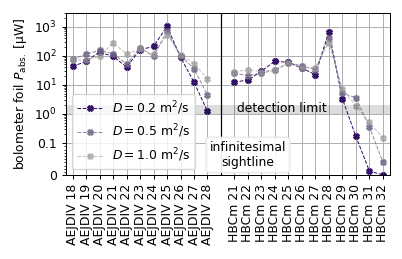

In [21]:
fig, ax = plt.subplots(figsize=(4.5,2.9))

total_label = [*A_labels_QRB, *A_labels_QSB]
total_label = [s[:-8] + s[-3:] for s in total_label]
tmp_x = np.array(range(1+len(total_label)))
tmp_x_tick = [*tmp_x[:len(A_labels_QRB)], *tmp_x[-len(A_labels_QSB):]]
mW_fac = 1000e3

for cpath in diff_paths:
    sum_QSB = QSB_all[cpath.stem] * A_etendue_QSB
    sum_QRB = QRB_all[cpath.stem] * A_etendue_QRB
    total_integrated = np.array([*sum_QRB, *sum_QSB])
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$D=$" + str(diffval) + " m$^2$/s"
    col=get_color(frad, diffval)
    
    y = mW_fac*total_integrated
    ax.errorbar(tmp_x, [*y[:len(A_labels_QRB)], np.nan, *y[-len(A_labels_QSB):]], color=col, fmt="X--", ms=4.5,
               label=label, lw=0.8)
    

ax.set_xticks(tmp_x_tick)
ax.set_xticklabels(total_label, rotation=90)
ax.set_xlim(-0.5, len(total_label)+0.5)
# ax.set_title(f"Calculated absorbed {bolotype} foil power and relative error of absorbed power calculated by the sightline approach.")
# ax.set_ylabel("Collected Power in $\mathrm{mW}$")
#ax.legend(loc=1)
ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0,3e3))
ax.vlines(len(A_labels_QRB), 0, 1e9, color="k", lw=1)
ax.set_ylabel("bolometer foil $P_{\mathrm{abs.}}$ [$\mathrm{\mu W}$]")
#plt.yticks(rotation = 90, ha="center", va="center")
ax.set_yticks([0,0.1,1,10,100,1000])
ax.set_yticks([*np.linspace(0,0.1,11), *np.linspace(0.1,1,10), *np.linspace(1,10,10),
               *np.linspace(10,100,10), *np.linspace(100,1000,10), 2000, 3000], minor=True)
ax.set_yticklabels(["0", "0.1", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

fig.tight_layout()
ax.grid()
ax.legend()

bbox_props = dict(boxstyle="round", fc="w", ec="0.9", alpha=0.9)
ax.text(13, 0.02, "infinitesimal\nsightline", ha="center", va="bottom", bbox=bbox_props)

ax.axhspan(1, 2, facecolor=(*(0.0,)*3, 2/15) , zorder=3)
ax.text(12.2, 0.9, "detection limit", ha="left", va="bottom")

fig.savefig(f"./plots/sightline_integration_diff_variation.png")
fig.savefig(f"./plots/sightline_integration_diff_variation.pdf")

## same thing with geometry matrix

In [23]:
# bolopower = xr.open_dataset(f"./data/matrixprod-power-all.nc")
# bolopower = bolopower.rename({"__xarray_dataarray_variable__":"power"})
bolopower = xr.open_dataset(f"./data/matrixprod-power-all.nc").__xarray_dataarray_variable__

In [24]:
# QSB 20:32, QRB 37:48
bp_qsb = bolopower.sel(bolotype="QSB").isel(id=slice(20,32))
bp_qrb = bolopower.sel(bolotype="QRB").isel(id=slice(37,48))

<IPython.core.display.Javascript object>


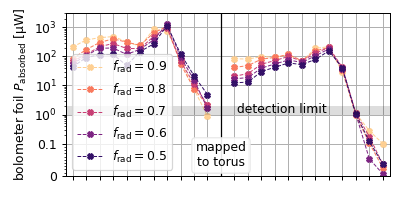

In [26]:
fig, ax = plt.subplots(figsize=(4.5,2.2))

total_label = [*A_labels_QRB, *A_labels_QSB]
total_label = [None for x in total_label]
tmp_x = np.array(range(1+len(total_label)))
tmp_x_tick = [*tmp_x[:len(A_labels_QRB)], *tmp_x[-len(A_labels_QSB):]]
mW_fac = 1000e3

for cpath in cpaths:
    sum_QSB = bp_qsb.sel(simulation=cpath.stem)
    sum_QRB = bp_qrb.sel(simulation=cpath.stem)
    total_integrated = np.array([*sum_QRB, *sum_QSB])
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label="$f_{\mathrm{rad}} =$" + str(frad)
    col=get_color(frad, diffval)
    
    y = mW_fac*total_integrated
    ax.errorbar(tmp_x, [*y[:len(A_labels_QRB)], np.nan, *y[-len(A_labels_QSB):]], color=col, fmt="X--", ms=4.5,
               label=label, lw=0.8)
    

ax.set_xticks(tmp_x_tick)
ax.set_xticklabels(total_label, rotation=90)
ax.set_xlim(-0.5, len(total_label)+0.5)
# ax.set_title(f"Calculated absorbed {bolotype} foil power and relative error of absorbed power calculated by the sightline approach.")
# ax.set_ylabel("Collected Power in $\mathrm{mW}$")
#ax.legend(loc=1)
ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0,3e3))
ax.vlines(len(A_labels_QRB), 0, 1e9, color="k", lw=1)
ax.set_ylabel("bolometer foil $P_{\mathrm{absorbed}}$ [$\mathrm{\mu W}$]")
#plt.yticks(rotation = 90, ha="center", va="center")
ax.set_yticks([0,0.1,1,10,100,1000])
ax.set_yticks([*np.linspace(0,0.1,11), *np.linspace(0.1,1,10), *np.linspace(1,10,10),
               *np.linspace(10,100,10), *np.linspace(100,1000,10), 2000, 3000], minor=True)
ax.set_yticklabels(["0", "0.1", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

fig.tight_layout()
ax.grid()
ax.legend()

bbox_props = dict(boxstyle="round", fc="w", ec="0.9", alpha=0.9)
ax.text(11, 0.02, "mapped\nto torus", ha="center", va="bottom", bbox=bbox_props)

ax.axhspan(1, 2, facecolor=(*(0.0,)*3, 2/15) , zorder=3)
ax.text(12.2, 0.9, "detection limit", ha="left", va="bottom")

fig.savefig(f"./plots/sightline_matrix_integration_frad_variation.png")
fig.savefig(f"./plots/sightline_matrix_integration_frad_variation.pdf")

<IPython.core.display.Javascript object>


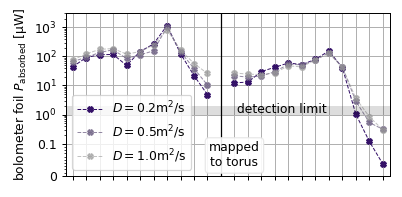

In [27]:
fig, ax = plt.subplots(figsize=(4.5,2.2))

total_label = [*A_labels_QRB, *A_labels_QSB]
total_label = [None for x in total_label]
tmp_x = np.array(range(1+len(total_label)))
tmp_x_tick = [*tmp_x[:len(A_labels_QRB)], *tmp_x[-len(A_labels_QSB):]]
mW_fac = 1000e3

for cpath in diff_paths:
    sum_QSB = bp_qsb.sel(simulation=cpath.stem)
    sum_QRB = bp_qrb.sel(simulation=cpath.stem)
    total_integrated = np.array([*sum_QRB, *sum_QSB])
    
    frad = float(cpath.stem[20:24])/float(cpath.stem[9:13])
    diffval = float(2 if cpath.stem[-1]=="C" else cpath.stem[-2:])/10
    label= "$D=$" + str(diffval) + "m$^2$/s"
    col=get_color(frad, diffval)
    
    y = mW_fac*total_integrated
    ax.errorbar(tmp_x, [*y[:len(A_labels_QRB)], np.nan, *y[-len(A_labels_QSB):]], color=col, fmt="X--", ms=4.5,
               label=label, lw=0.8)
    

ax.set_xticks(tmp_x_tick)
ax.set_xticklabels(total_label, rotation=90)
ax.set_xlim(-0.5, len(total_label)+0.5)
# ax.set_title(f"Calculated absorbed {bolotype} foil power and relative error of absorbed power calculated by the sightline approach.")
# ax.set_ylabel("Collected Power in $\mathrm{mW}$")
#ax.legend(loc=1)
ax.set_yscale("symlog", linthresh=1e-1)
ax.set_ylim((0,3e3))
ax.vlines(len(A_labels_QRB), 0, 1e9, color="k", lw=1)
ax.set_ylabel("bolometer foil $P_{\mathrm{absorbed}}$ [$\mathrm{\mu W}$]")
#plt.yticks(rotation = 90, ha="center", va="center")
ax.set_yticks([0,0.1,1,10,100,1000])
ax.set_yticks([*np.linspace(0,0.1,11), *np.linspace(0.1,1,10), *np.linspace(1,10,10),
               *np.linspace(10,100,10), *np.linspace(100,1000,10), 2000, 3000], minor=True)
ax.set_yticklabels(["0", "0.1", "$10^0$", "$10^1$", "$10^2$", "$10^3$"])

fig.tight_layout()
ax.grid()
ax.legend()

bbox_props = dict(boxstyle="round", fc="w", ec="0.9", alpha=0.9)
ax.text(12, 0.02, "mapped\nto torus", ha="center", va="bottom", bbox=bbox_props)

ax.axhspan(1, 2, facecolor=(*(0.0,)*3, 2/15) , zorder=3)
ax.text(12.2, 0.9, "detection limit", ha="left", va="bottom")

fig.savefig(f"./plots/sightline_matrix_integration_diff_variation.png")
fig.savefig(f"./plots/sightline_matrix_integration_diff_variation.pdf")